In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import plotly
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack, coo_matrix
from scipy import sparse
import gensim 
from gensim.models import Word2Vec 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [39]:
df = pd.read_csv("preprocessed_data.csv", nrows=55000)

In [40]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [41]:
df.shape

(55000, 10)

In [42]:
df = df.dropna()
df.shape

(54973, 10)

In [43]:
len(df.columns)

10

In [44]:
df.columns.values.reshape(-1, 1)

array([['school_state'],
       ['teacher_prefix'],
       ['project_grade_category'],
       ['teacher_number_of_previously_posted_projects'],
       ['project_is_approved'],
       ['clean_categories'],
       ['clean_subcategories'],
       ['essay'],
       ['price'],
       ['project_title']], dtype=object)

In [45]:
Y = df['project_is_approved']
X = df.drop(['project_is_approved'], axis=1)

In [46]:

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, stratify=Y)


# Vectorizing PRICE

In [47]:

normalizer_price = Normalizer()
normalizer_price.fit(x_train['price'].values.reshape(-1, 1))

x_train_price_norm = normalizer_price.transform(x_train['price'].values.reshape(-1, 1))
x_test_price_norm = normalizer_price.transform(x_test['price'].values.reshape(-1,1))

x_train_price_norm.shape

(36831, 1)

# Vectorizing Teacher number of previously posted projects

In [48]:
normalizer_teacher_number_of_previously_posted_projects = Normalizer()

normalizer_teacher_number_of_previously_posted_projects.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

x_train_pre_posted_norm = normalizer_teacher_number_of_previously_posted_projects.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
# x_cv_pre_posted_norm = normalizer_teacher_number_of_previously_posted_projects.transform(x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
x_test_pre_posted_norm = normalizer_teacher_number_of_previously_posted_projects.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

x_train_pre_posted_norm.shape

(36831, 1)

# Essay TFIDF

In [49]:
tfidfVectorizer_essay = TfidfVectorizer(min_df=10)
tfidfVectorizer_essay.fit(x_train['essay'])
                          
            

x_train_essay_tfidf = tfidfVectorizer_essay.transform(x_train['essay'])
x_test_essay_tfidf = tfidfVectorizer_essay.transform(x_test['essay'])

tfidf_dictionary = dict(zip(tfidfVectorizer_essay.get_feature_names(), list(tfidfVectorizer_essay.idf_)))
tfidf_words = set(tfidfVectorizer_essay.get_feature_names())

x_train_essay_tfidf.shape, x_test_essay_tfidf.shape

((36831, 10748), (18142, 10748))

# Essay TFIDF_W2V

In [50]:
x_train_essay_w2v_tfidf = []
x_test_essay_w2v_tfidf = []


# x_train essay w2v_tfidf
for sentence in x_train['essay']:
    vector = np.zeros(300)
    tfidf_sum = 0

    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            w2v = model[word]
            tfidf = tfidf_dictionary[word] * ((sentence.count(word)) / (len(sentence.split())))
            vector = vector + np.multiply(w2v, tfidf)

    x_train_essay_w2v_tfidf.append(vector)



# x_test essay w2v_tfidf
for sentence in x_test['essay']:
    vector = np.zeros(300)
    tfidf_sum = 0

    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            w2v = model[word]
            tfidf = tfidf_dictionary[word] * ((sentence.count(word)) / (len(sentence.split())))
            vector = vector + np.multiply(tfidf, w2v)
  
    x_test_essay_w2v_tfidf.append(vector)

# Project Title TFIDF

In [51]:
tfidfVectorizer_title = TfidfVectorizer(min_df=10)
tfidfVectorizer_title.fit(x_train['project_title'].values.astype('U'))
                          
            

x_train_project_title_tfidf = tfidfVectorizer_title.transform(x_train['project_title'].values.astype('U'))
x_test_project_title_tfidf = tfidfVectorizer_title.transform(x_test['project_title'].values.astype('U'))

tfidf_dictionary = dict(zip(tfidfVectorizer_title.get_feature_names(), list(tfidfVectorizer_title.idf_)))
tfidf_words = set(tfidfVectorizer_title.get_feature_names())

# Project title TFIDF_W2V

In [52]:
x_train_project_title_w2v_tfidf = []
x_test_project_title_w2v_tfidf = []


# x_train essay w2v_tfidf
for sentence in x_train['project_title'].values.astype('U'):

    vector = np.zeros(300)
    tfidf_sum = 0

    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            w2v = model[word]
            tfidf = tfidf_dictionary[word] * ((sentence.count(word)) / (len(sentence.split())))

            vector = vector + np.multiply(w2v, tfidf)
  

  
    x_train_project_title_w2v_tfidf.append(vector)



# x_test essay w2v_tfidf
for sentence in x_test['essay'].values.astype('U'):
    vector = np.zeros(300)
    tfidf_sum = 0

    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            w2v = model[word]
            tfidf = tfidf_dictionary[word] * ((sentence.count(word)) / (len(sentence.split())))
            vector = vector + np.multiply(tfidf, w2v)
  
    x_test_project_title_w2v_tfidf.append(vector)


# Response Code school_state

In [53]:
dict_school_state = {}
school_state_response_code = []

# Creating dictionary for state and counts
for school_state_cat_var, is_approved_var in zip(x_train['school_state'], y_train):
    
    if is_approved_var == 0:
        if school_state_cat_var in dict_school_state:
            dict_school_state[school_state_cat_var][0] += 1
            
        else: 
            dict_school_state[school_state_cat_var] = [1, 1]
            
    if is_approved_var == 1:
        if school_state_cat_var in dict_school_state:
            dict_school_state[school_state_cat_var][1] += 1
            
        else:
            dict_school_state[school_state_cat_var] = [1, 1]
    
# Updating values for each state as probabilities
for state in dict_school_state:
    value = dict_school_state[state]
    sample_space = value[0] + value[1]
    value[0] = np.around(value[0] / sample_space, 5)
    value[1] = np.around(value[1] / sample_space, 5)
    
    dict_school_state[state] = value
 

In [54]:
x_train_school_state_response_code = []
x_test_school_state_response_code = []


for state in x_train["school_state"]:
    x_train_school_state_response_code.append(np.asarray(dict_school_state[state]))
    
        
for state in x_test["school_state"]:
    
    if state in dict_school_state:
        x_test_school_state_response_code.append(np.asarray(dict_school_state[state]))
    else:
        x_test_school_state_response_code.append(np.asarray([0.5, 0.5]))
    




    

# Response Code teacher_prefix

In [55]:
dict_teacher_prefix = {}
teacher_prefix_response_code = []

# Creating dictionary for state and counts
for teacher_prefix_cat_var, is_approved_var in zip(x_train['teacher_prefix'], y_train):
    
    if is_approved_var == 0:
        if teacher_prefix_cat_var in dict_teacher_prefix:
            dict_teacher_prefix[teacher_prefix_cat_var][0] += 1
            
        else: 
            dict_teacher_prefix[teacher_prefix_cat_var] = [1, 1]
            
    if is_approved_var == 1:
        if teacher_prefix_cat_var in dict_teacher_prefix:
            dict_teacher_prefix[teacher_prefix_cat_var][1] += 1
            
        else:
            dict_teacher_prefix[teacher_prefix_cat_var] = [1, 1]
    
# Updating values for each state as probabilities
for teacher_prefix_cat_var in dict_teacher_prefix:
    value = dict_teacher_prefix[teacher_prefix_cat_var]
    sample_space = value[0] + value[1]
    value[0] = np.around(value[0] / sample_space, 5)
    value[1] = np.around(value[1] / sample_space, 5)
    
    dict_teacher_prefix[teacher_prefix_cat_var] = value
 

In [56]:
x_train_teacher_prefix_response_code = []
x_test_teacher_prefix_response_code = []


for teacher_prefix in x_train["teacher_prefix"]:
    x_train_teacher_prefix_response_code.append(np.asarray(dict_teacher_prefix[teacher_prefix]))
        
    
for teacher_prefix in x_test["teacher_prefix"]:
    if teacher_prefix in dict_teacher_prefix:
        x_test_teacher_prefix_response_code.append(np.asarray(dict_teacher_prefix[teacher_prefix]))
    else:
        x_test_teacher_prefix_response_code.append(np.asarray([0.5, 0.5]))
    




# Response Code project_grade_category

In [57]:
dict_project_grade_category = {}
project_grade_category_response_code = []

# Creating dictionary for state and counts
for project_grade_category_cat_var, is_approved_var in zip(x_train['project_grade_category'], y_train):
    
    if is_approved_var == 0:
        if project_grade_category_cat_var in dict_project_grade_category:
            dict_project_grade_category[project_grade_category_cat_var][0] += 1
            
        else: 
            dict_project_grade_category[project_grade_category_cat_var] = [1, 1]
            
    if is_approved_var == 1:
        if project_grade_category_cat_var in dict_project_grade_category:
            dict_project_grade_category[project_grade_category_cat_var][1] += 1
            
        else:
            dict_project_grade_category[project_grade_category_cat_var] = [1, 1]
    
# Updating values for each state as probabilities
for project_grade_category_cat_var in dict_project_grade_category:
    value = dict_project_grade_category[project_grade_category_cat_var]
    sample_space = value[0] + value[1]
    value[0] = np.around(value[0] / sample_space, 5)
    value[1] = np.around(value[1] / sample_space, 5)
    
    dict_project_grade_category[project_grade_category_cat_var] = value

In [58]:
x_train_project_grade_category_response_code = []
x_test_project_grade_category_response_code = []


for project_grade_category in x_train["project_grade_category"]:
    x_train_project_grade_category_response_code.append(np.asarray(dict_project_grade_category[project_grade_category]))
        
    
    
for project_grade_category in x_test["project_grade_category"]:
    
    if teacher_prefix in dict_teacher_prefix:
        x_test_project_grade_category_response_code.append(np.asarray(dict_project_grade_category[project_grade_category]))
    else:
        x_test_project_grade_category_response_code.append(np.asarray([0.5, 0.5]))
        


# Response Code clean_categories

In [59]:
dict_clean_categories = {}
clean_categories_response_code = []

# Creating dictionary for state and counts
for clean_categories_cat_var, is_approved_var in zip(x_train['clean_categories'], y_train):
    
    if is_approved_var == 0:
        if clean_categories_cat_var in dict_clean_categories:
            dict_clean_categories[clean_categories_cat_var][0] += 1
            
        else: 
            dict_clean_categories[clean_categories_cat_var] = [1, 1]
            
    if is_approved_var == 1:
        if clean_categories_cat_var in dict_clean_categories:
            dict_clean_categories[clean_categories_cat_var][1] += 1
            
        else:
            dict_clean_categories[clean_categories_cat_var] = [1, 1]
    
# Updating values for each state as probabilities
for clean_categories_cat_var in dict_clean_categories:
    value = dict_clean_categories[clean_categories_cat_var]
    sample_space = value[0] + value[1]
    value[0] = np.around(value[0] / sample_space, 5)
    value[1] = np.around(value[1] / sample_space, 5)
    
    dict_clean_categories[clean_categories_cat_var] = value
 

In [60]:
x_train_clean_categories_response_code = []
x_test_clean_categories_response_code = []


for clean_categories in x_train["clean_categories"]:
    x_train_clean_categories_response_code.append(np.asarray(dict_clean_categories[clean_categories]))
    

        
        
for clean_categories in x_test["clean_categories"]:
    
    if clean_categories in dict_clean_categories:
        x_test_clean_categories_response_code.append(np.asarray(dict_clean_categories[clean_categories]))
        
    else: x_test_clean_categories_response_code.append(np.asarray([0.5, 0.5]))
    


# Response Code clean_subcategories

In [61]:
dict_clean_subcategories = {}
clean_subcategories_response_code = []

# Creating dictionary for state and counts
for clean_subcategories_cat_var, is_approved_var in zip(x_train['clean_subcategories'], y_train):
    
    if is_approved_var == 0:
        if clean_subcategories_cat_var in dict_clean_subcategories:
            dict_clean_subcategories[clean_subcategories_cat_var][0] += 1
            
        else: 
            dict_clean_subcategories[clean_subcategories_cat_var] = [1, 1]
            
    if is_approved_var == 1:
        if clean_subcategories_cat_var in dict_clean_subcategories:
            dict_clean_subcategories[clean_subcategories_cat_var][1] += 1
            
        else:
            dict_clean_subcategories[clean_subcategories_cat_var] = [1, 1]
    
# Updating values for each state as probabilities
for clean_subcategories_cat_var in dict_clean_subcategories:
    value = dict_clean_subcategories[clean_subcategories_cat_var]
    sample_space = value[0] + value[1]
    value[0] = np.around(value[0] / sample_space, 5)
    value[1] = np.around(value[1] / sample_space, 5)
    
    dict_clean_subcategories[clean_subcategories_cat_var] = value
 

In [62]:
x_train_clean_subcategories_response_code = []
x_test_clean_subcategories_response_code = []


for clean_subcategories in x_train["clean_subcategories"]:
    x_train_clean_subcategories_response_code.append(np.asarray(dict_clean_subcategories[clean_subcategories]))
        
        
for clean_subcategories in x_test["clean_subcategories"]:
    
    if clean_subcategories in dict_clean_subcategories:
        x_test_clean_subcategories_response_code.append(np.asarray(dict_clean_subcategories[clean_subcategories]))
        
    else: x_test_clean_subcategories_response_code.append(np.asarray([0.5, 0.5]))
    
    

# Sentiment Scoring

In [63]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


sid = SentimentIntensityAnalyzer()

x_train_sentiment_scores = np.empty((x_train.shape[0], 4))
x_test_sentiment_scores = np.empty((x_test.shape[0], 4))

for i, sentence in enumerate(x_train['essay']):
    temp_ss = sid.polarity_scores(sentence)
    x_train_sentiment_scores[i][0] = temp_ss['neg']
    x_train_sentiment_scores[i][1] = temp_ss['neu']
    x_train_sentiment_scores[i][2] = temp_ss['pos']
    x_train_sentiment_scores[i][3] = temp_ss['compound']


for i, sentence in enumerate(x_test['essay']):
    temp_ss = sid.polarity_scores(sentence)
    x_test_sentiment_scores[i][0] = temp_ss['neg']
    x_test_sentiment_scores[i][1] = temp_ss['neu']
    x_test_sentiment_scores[i][2] = temp_ss['pos']
    x_test_sentiment_scores[i][3] = temp_ss['compound']




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\K9\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Set-1 Data

In [64]:
x_tr_set_1 = hstack((x_train_price_norm,
                     x_train_pre_posted_norm,
                     x_train_clean_subcategories_response_code,
                     x_train_project_grade_category_response_code,
                     x_train_clean_categories_response_code,
                     x_train_essay_tfidf,
                     x_train_teacher_prefix_response_code,
                     x_train_sentiment_scores,
                     x_train_school_state_response_code,
                     x_train_project_title_tfidf))

x_te_set_1 = hstack((x_test_price_norm,
                     x_test_pre_posted_norm,
                     x_test_clean_subcategories_response_code,
                     x_test_clean_categories_response_code,
                     x_test_project_grade_category_response_code,
                     x_test_essay_tfidf,
                     x_test_teacher_prefix_response_code,
                     x_test_sentiment_scores,
                     x_test_school_state_response_code,
                     x_test_project_title_tfidf))

x_tr_set_1.shape, x_te_set_1.shape

((36831, 12429), (18142, 12429))

# Set-2 Data

In [65]:
# x_train_essay_w2v_tfidf,
# x_train_project_title_w2v_tfidf


x_tr_set_2 = np.hstack((x_train_price_norm,
                        x_train_pre_posted_norm,
                        x_train_clean_subcategories_response_code,
                        x_train_clean_categories_response_code,
                        x_train_project_grade_category_response_code,
                        x_train_essay_w2v_tfidf,
                        x_train_teacher_prefix_response_code,
                        x_train_sentiment_scores,
                        x_train_school_state_response_code, 
                        x_train_project_title_w2v_tfidf))



x_te_set_2 = np.hstack((x_test_price_norm,
                       x_test_pre_posted_norm,
                       x_test_clean_subcategories_response_code,
                       x_test_clean_categories_response_code,
                       x_test_project_grade_category_response_code,
                       x_test_essay_w2v_tfidf,
                       x_test_teacher_prefix_response_code,
                       x_test_sentiment_scores,
                       x_test_school_state_response_code,
                       x_test_project_title_w2v_tfidf))

x_tr_set_2.shape, x_te_set_2.shape

((36831, 616), (18142, 616))

In [66]:
XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

# Hyperparameter tunning

## Predicting set-1

In [67]:
param_grid = {
   'max_depth':[1, 5, 10,20 , 30],
    "n_estimators":[50, 100, 200, 250, 300]
    
}

clfs = GridSearchCV(estimator=XGBClassifier(),
                    param_grid=param_grid,
                    cv=2,
                    scoring="roc_auc",
                    n_jobs=4,
                    verbose=True,
                    return_train_score=True)

clfs.fit(x_tr_set_1, y_train)



Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 33.0min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 47.5min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

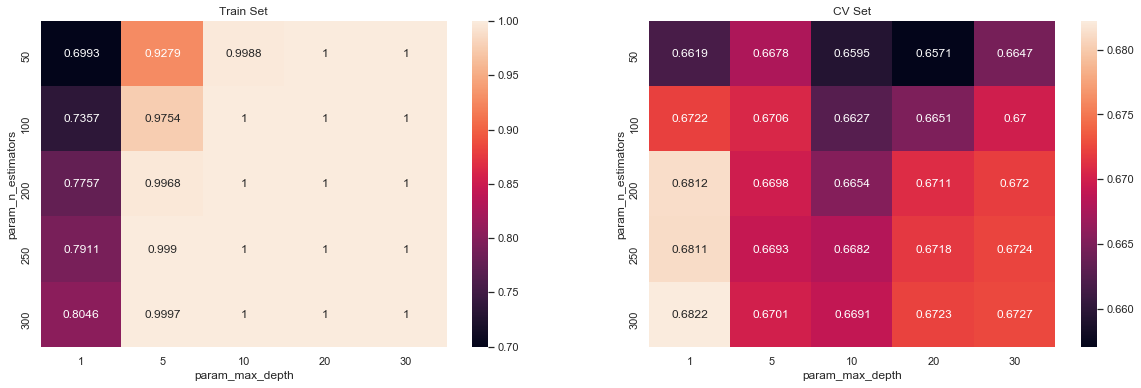

In [68]:
mean_train_score = clfs.cv_results_['mean_train_score']
mean_test_score = clfs.cv_results_['mean_test_score']
params = clfs.cv_results_['params']

import seaborn as sns; sns.set()

max_scores = pd.DataFrame(clfs.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [69]:

set_1_max_depth = clfs.best_params_['max_depth']
set_1_n_estimator = clfs.best_params_['n_estimators']

param_grid = {
   'max_depth':[clfs.best_params_['max_depth']],
    "n_estimators":[clfs.best_params_['n_estimators']]
    
}

clf_set1 = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid)
clf_set1.fit(x_tr_set_1, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
       

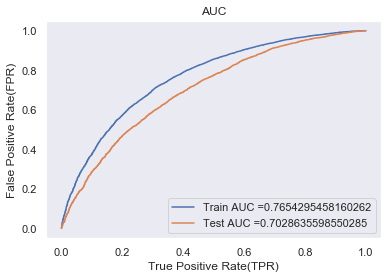

In [70]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

train_fpr, train_tpr, train_thresholds = roc_curve(y_true=y_train, y_score=clf_set1.predict_proba(x_tr_set_1.tocsr())[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=y_test, y_score=clf_set1.predict_proba(x_te_set_1.tocsr())[:,1])

# Set-1 Test AUC Score
set1_AUC_score = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [71]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, clf_set1.predict(x_te_set_1.tocsr()))
cf_matrix

array([[   37,  2863],
       [   19, 15223]], dtype=int64)

## Predicting Set -2

In [72]:
param_grid = {
    
   'max_depth':[1, 5, 10,20 , 30],
    "n_estimators":[50, 100, 200, 250, 300]
    
}

clfs = GridSearchCV(estimator=XGBClassifier(),
                    param_grid=param_grid,
                    cv=2,
                    scoring="roc_auc",
                    n_jobs=4,
                    verbose=True,
                    return_train_score=True)

clfs.fit(x_tr_set_2, y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 72.6min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 96.0min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

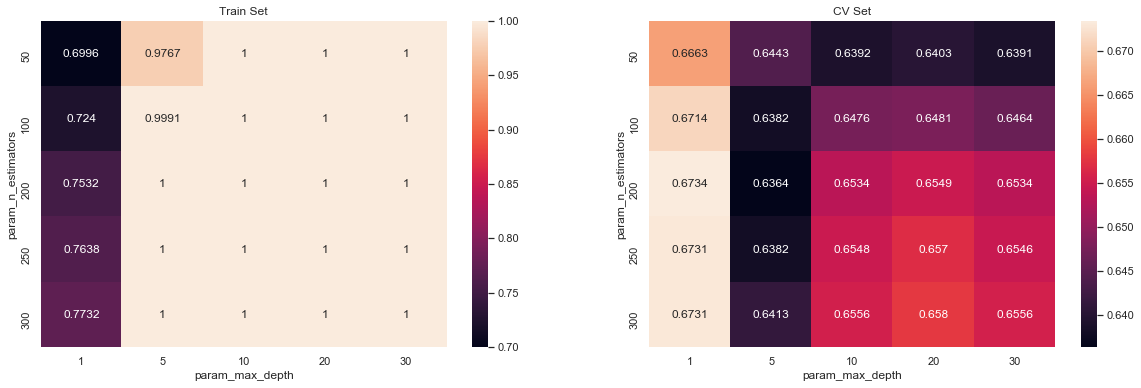

In [73]:
mean_train_score = clfs.cv_results_['mean_train_score']
mean_test_score = clfs.cv_results_['mean_test_score']
params = clfs.cv_results_['params']

import seaborn as sns; sns.set()

max_scores = pd.DataFrame(clfs.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [74]:
param_grid = {
   'max_depth':[clfs.best_params_['max_depth']],
    "n_estimators":[clfs.best_params_['n_estimators']]
    
}
# best value for max_depth
set_2_max_depth = clfs.best_params_['max_depth']
# best value for n_estimators
set_2_n_estimator = clfs.best_params_['n_estimators']

clf_set2 = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid)
clf_set2.fit(x_tr_set_2, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
       

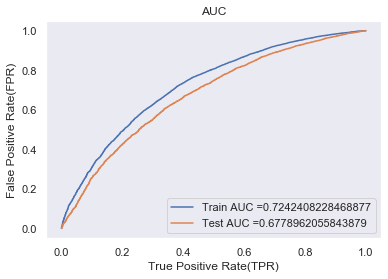

In [75]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

train_fpr, train_tpr, train_thresholds = roc_curve(y_true=y_train, y_score=clf_set2.predict_proba(x_tr_set_2)[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=y_test, y_score=clf_set2.predict_proba(x_te_set_2)[:,1])

# set 2 - Test AUC score
set2_AUC_score = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [76]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, clf_set2.predict(x_te_set_2))
cf_matrix

array([[    9,  2891],
       [    8, 15234]], dtype=int64)

# Result

In [77]:
from prettytable import PrettyTable

t = PrettyTable(['Vectorizer', 'Model', 'Max_depth', 'n_estimators', 'AUC'])
t.add_row(['TF-IDF', 'XGBOOST',set_1_max_depth, set_1_n_estimator, set1_AUC_score])
t.add_row(['TF-IDF_W2V', 'XGBOOST', set_2_max_depth, set_2_n_estimator, set2_AUC_score])
print(t)

+------------+---------+-----------+--------------+--------------------+
| Vectorizer |  Model  | Max_depth | n_estimators |        AUC         |
+------------+---------+-----------+--------------+--------------------+
|   TF-IDF   | XGBOOST |     1     |     300      | 0.7028635598550285 |
| TF-IDF_W2V | XGBOOST |     1     |     200      | 0.6778962055843879 |
+------------+---------+-----------+--------------+--------------------+
